# Dataset

### Download the dataset

In [1]:
# Dataset link https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/

In [2]:
!wget https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip

--2024-02-01 15:16:20--  https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  71.1MB/s    in 1.6s    

2024-02-01 15:16:22 (71.1 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]



In [3]:
!unzip -q horse2zebra.zip

### Explore the dataset

In [4]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
trainA_path = "horse2zebra/trainA/"
trainB_path = "horse2zebra/trainB/"
testA_path = "horse2zebra/testA/"
testB_path = "horse2zebra/testB/"

trainA = [trainA_path + img_name for img_name in os.listdir(trainA_path)]
trainB = [trainB_path + img_name for img_name in os.listdir(trainB_path)]
testA = [testA_path + img_name for img_name in os.listdir(testA_path)]
testB = [testB_path + img_name for img_name in os.listdir(testB_path)]

In [6]:
trainA[0]

'horse2zebra/trainA/n02381460_421.jpg'

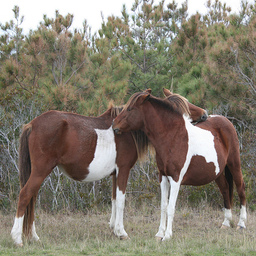

In [7]:
Image.open(trainA[5])

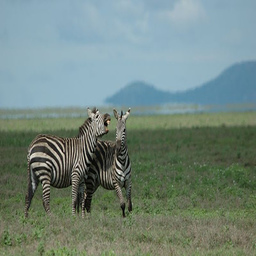

In [8]:
Image.open(trainB[2])

### Data Preprocessing

In [9]:
# def load(img_path):
#     image = tf.io.read_file(img_path)
#     image = tf.image.decode_jpeg(image)
#     image = tf.image.resize(image, [256, 256], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
#     return tf.cast(image, tf.float32)

# def random_jitter(image):
#     image = tf.image.random_flip_left_right(image)
#     return image

# def preprocess_image_train(image):
#     image = load(image)
#     image = random_jitter(image)
#     image = (image / 127.5) - 1
#     return image

# def preprocess_image_test(image):
#     image = load(image)
#     image  = (image / 127.5) - 1
#     return image

In [10]:
def load(img_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [256, 256], method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return tf.cast(image, tf.float32)

In [11]:
def preprocess_train(img_path):
    image = load(img_path)
    image = tf.image.random_flip_left_right(image)
    return (image / 127.5) - 1

def preprocess_test(img_path):
    image = load(img_path)
    return (image / 127.5) - 1

In [12]:
def imshow(img, norm=True):
    if norm: img = (img[0]*0.5)+0.5
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [13]:
trainA = tf.data.Dataset.from_tensor_slices((trainA))
trainB = tf.data.Dataset.from_tensor_slices((trainB))
testA = tf.data.Dataset.from_tensor_slices((testA))
testB = tf.data.Dataset.from_tensor_slices((testB))

In [14]:
trainA = trainA.map(preprocess_train).cache().shuffle(100).batch(1)
trainB = trainB.map(preprocess_train).cache().shuffle(100).batch(1)
testA = testA.map(preprocess_test).cache().batch(1)
testB = testB.map(preprocess_test).cache().batch(1)

In [15]:
im1_test = next(iter(trainA))
im1_test.shape

TensorShape([1, 256, 256, 3])

In [16]:
im2_test = next(iter(testB))
im2_test.shape

TensorShape([1, 256, 256, 3])

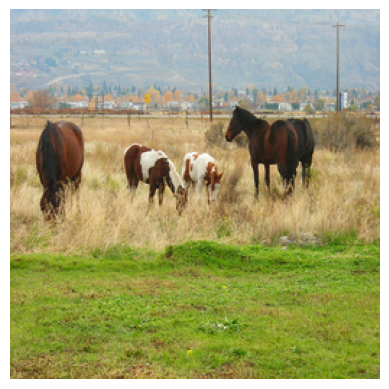

In [17]:
imshow(im1_test)

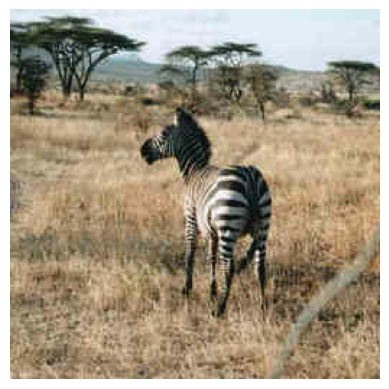

In [18]:
imshow(im2_test)

# Models

### Download the model and instantiate the objects

In [19]:
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 23737, done.
remote: Counting objects: 100% (701/701), done.
remote: Compressing objects: 100% (428/428), done.
remote: Total 23737 (delta 230), reused 557 (delta 185), pack-reused 23036
Receiving objects: 100% (23737/23737), 44.19 MiB | 18.13 MiB/s, done.
Resolving deltas: 100% (12878/12878), done.


In [20]:
from examples.tensorflow_examples.models.pix2pix import pix2pix

# If you have a GPU, uncomment the next two lines
# devices = tf.config.experimental.get_visible_devices("GPU")
# tf.config.experimental.set_memory_growth(device=devices[0], enable = True)

In [21]:
gen_g = pix2pix.unet_generator(output_channels=3, norm_type='instancenorm')
gen_f = pix2pix.unet_generator(output_channels=3, norm_type='instancenorm')

disc_x = pix2pix.discriminator(norm_type="instancenorm", target = False)
disc_y = pix2pix.discriminator(norm_type="instancenorm", target = False)

In [22]:
h2z = gen_g(im1_test)
z2h = gen_f(im2_test)

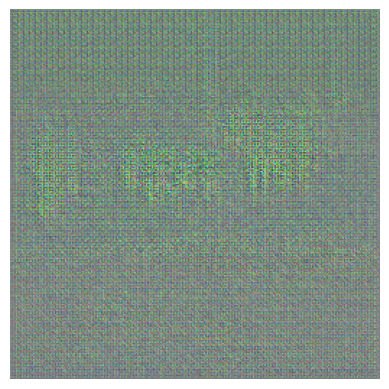

In [23]:
imshow(h2z)

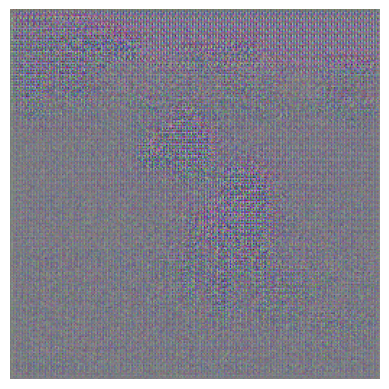

In [24]:
imshow(z2h)

### Losses Functions and The Optimizers

In [25]:
BCELoss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [26]:
def disc_loss(real, fake):
    real_loss = BCELoss(tf.ones_like(real), real)
    fake_loss = BCELoss(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

In [27]:
def gen_loss(generated):
    return BCELoss(tf.ones_like(generated), generated)

In [28]:
def cycle_consistency_loss(real_image, generated_image, lambda_val=10):
    return lambda_val * tf.reduce_mean(tf.abs(real_image - generated_image))

In [29]:
def identity_loss(real_image, same_image, lambda_val=5):
    return lambda_val * tf.reduce_mean(tf.abs(real_image - same_image))

In [30]:
gen_g_opt = tf.keras.optimizers.Adam()
gen_f_opt = tf.keras.optimizers.Adam()

disc_x_opt = tf.keras.optimizers.Adam()
disc_y_opt = tf.keras.optimizers.Adam()

# Training

### Before Training

In [31]:
def n_epoch_results_save(generator, inp_img, epoch):
    prediction = generator(inp_img) # inp_shape = out_shape = (1, 256, 256, 3)

    images = [inp_img[0], prediction[0]]
    titles = ['Input_Image', 'Generated_Image']
    plt.figure(figsize=(15, 12))

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(titles[i])
        plt.imshow(images[i]*0.5 + 0.5) # Rescale from [-1, 1] to [0, 1]
        plt.axis('off')

    if not os.path.exists('results'): os.mkdir('results')
    plt.savefig(f"results/epoch_{epoch+1}.jpg")
    # plt.close()

### Training

In [32]:
from tqdm import tqdm

In [36]:
@tf.function
def train_step(real_x, real_y): # x=Zebra   y=Horse
    with tf.GradientTape(persistent=True) as tape:
        fake_y = gen_g(real_x, training = True)
        cycle_x = gen_f(fake_y, training = True)

        fake_x = gen_f(real_y, training = True)
        cycle_y = gen_g(fake_x, training = True)

        same_x = gen_f(real_x, training = True)
        same_y = gen_g(real_y, training = True)

        disc_real_x = disc_x(real_x, training = True)
        disc_real_y = disc_y(real_y, training = True)

        disc_fake_x = disc_x(fake_x, training = True)
        disc_fake_y = disc_y(fake_y, training = True)

        # Losses
        gen_g_loss = gen_loss(disc_fake_y)
        gen_f_loss = gen_loss(disc_fake_x)
        total_cycle_loss = cycle_consistency_loss(real_x, cycle_y) + cycle_consistency_loss(real_y, cycle_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = disc_loss(disc_real_x, disc_fake_x)
        disc_y_loss = disc_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients
    generator_g_grad = tape.gradient(total_gen_g_loss, gen_g.trainable_variables)
    generator_f_grad = tape.gradient(total_gen_f_loss, gen_f.trainable_variables)

    discriminator_x_grad = tape.gradient(disc_x_loss, disc_x.trainable_variables)
    discriminator_y_grad = tape.gradient(disc_y_loss, disc_y.trainable_variables)

    # Optimizers
    gen_g_opt.apply_gradients(zip(generator_g_grad, gen_g.trainable_variables))
    gen_f_opt.apply_gradients(zip(generator_f_grad, gen_f.trainable_variables))

    disc_x_opt.apply_gradients(zip(discriminator_x_grad, disc_x.trainable_variables))
    disc_y_opt.apply_gradients(zip(discriminator_y_grad, disc_y.trainable_variables))

    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [42]:
epochs = 1
iter_testA = iter(testA)
for epoch in range(epochs):
    for image_x, image_y in tqdm(zip(trainA, trainB), total=len(trainA)):  # tf.data.Dataset.zip((trainA, trainB))
        gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y)
    print(f"\nEpoch: {epoch + 1}\nG_g_loss: {round(gen_g_loss, 4)} ------ G_f_loss: {round(gen_f_loss, 4)}\
                                 disc_x_loss: {round(disc_x_loss, 4)} ------ disc_y_loss: {round(disc_y_loss, 4)}")
    test = next(iter_testA)
    n_epoch_results_save(gen_g, test, epoch)

  0%|          | 0/1067 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
if not os.path.exists("weights/"): os.mkdir("weights/")

gen_f.save_weights("weights/generator_f.h5")
gen_g.save_weights("weights/generator_g.h5")
disc_x.save_weights("weights/disc_x.h5")
disc_y.save_weights("weights/disc_y.h5")

# Testing

In [ ]:
gen_f.load_weights("weights/generator_f.h5")
gen_g.load_weights("weights/generator_g.h5")
disc_x.load_weights("weights/disc_x.h5")
disc_y.load_weights("weights/disc_y.h5")

In [ ]:
image = preprocess_test("apple2orange/testA/n07740461_14621.jpg")
image = image[tf.newaxis, :]
imshow(image)

In [ ]:
pred = gen_g(image)
imshow(pred)